<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Bioseñales y Sistemas </center></font></h1>
<h2><font color='0B5345'> <center>
SISTEMA DE DETECCIÓN DE MOVIMIENTO MUSCULAR  </center></font></h2>
<h4><font color='0B5345'>
<center></center>
<center>Diego Flórez - Daniel Soto - Melissa Cadavid</center>
</font></h4>

<font  face="Courier New" size="3">
<p1><center> </center></p1>



<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia</font></b> </center></p3>
</font>

# **Programar en el microcontrolador las rutinas que permiten una mejor discriminación de movimientos encontradas en el proyecto 1 y 2. Tener en cuenta las limitaciones de procesamiento que hay en los microcontroladores.**

Para esto, primero necesitamos filtrar nuestras señales con un filtro de pasa altas, debido a que el microcontrolador ya cuenta con un filtro pasa bajas, permitiendonos asi crear un pasa bandas, que nos permite facilitar el procesamiento y detección de las señales.

Mounted at /content/drive
El archivo datos1.mat no se encontró en la ruta especificada.


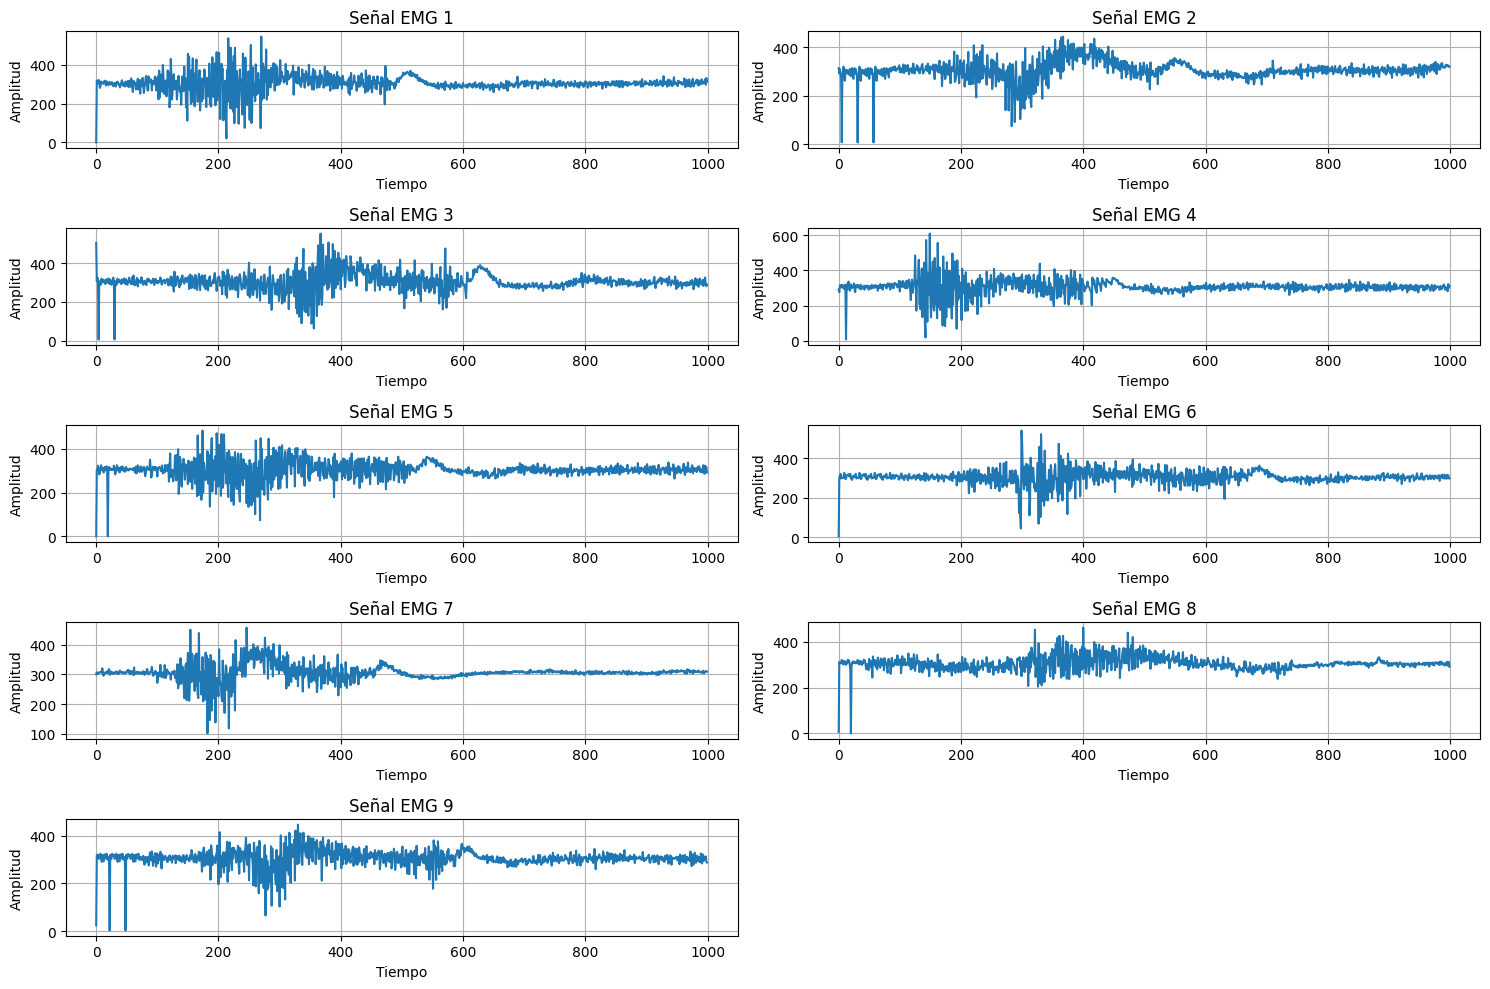

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar las bibliotecas necesarias
import os
import scipy.io as sio
import matplotlib.pyplot as plt

# Definir la ruta del directorio donde se encuentran los archivos .mat
directory = '/content/drive/MyDrive/EMGP2/senales2'

# Inicializar una lista para almacenar las señales EMG
signals_emg = []

# Iterar sobre los archivos .mat y cargar las señales EMG
for i in range(1, 11):
    filename = f'datos{i}.mat'
    filepath = os.path.join(directory, filename)
    if os.path.exists(filepath):
        data = sio.loadmat(filepath)
        # Extraer la señal EMG de los datos cargados
        senal_emg = data['EMG']
        signals_emg.append(senal_emg[0])  # Añadir la primera fila de la matriz como señal EMG
    else:
        print(f"El archivo {filename} no se encontró en la ruta especificada.")

# Crear un vector de tiempo basado en el número de puntos de la señal
tiempo = range(len(signals_emg[0]))

# Tramar todas las señales EMG
plt.figure(figsize=(15, 10))
for i, signal_emg in enumerate(signals_emg, start=1):
    plt.subplot(5, 2, i)
    plt.plot(tiempo, signal_emg)
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EMG {i}')
    plt.grid(True)

plt.tight_layout()
plt.show()



Para realizar el filtro se utiliza un pasa altas Butterworth nos permite eliminar componentes de baja frecuencia que no son de interes como artefactos de movimiento o interferencia eléctrica, al eliminar este ruido de baja frecuencia, se mejora la relación señal-ruido de la señal EMG. Esto puede facilitar la detección y análisis de eventos específicos, como el movimiento de flexión y extensión del músculo.
Para el filtro se toma un orden 4 debido a que un orden bajo nos permite obtener una banda de transición más ancha, de esta forma hay menos distorsión.

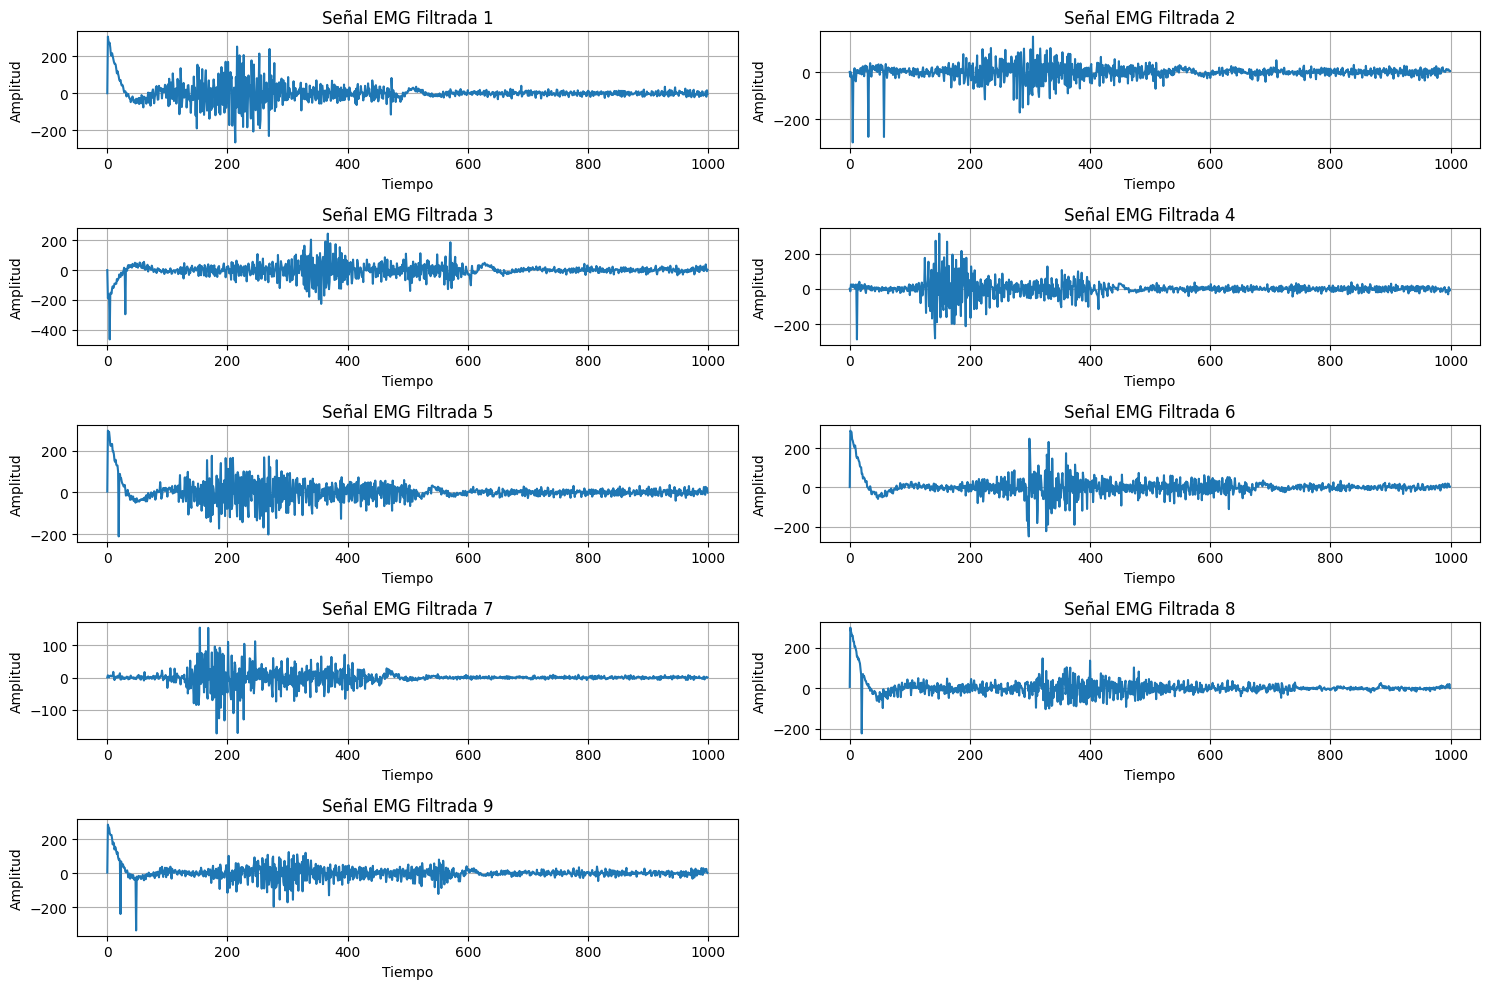

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

# Función para diseñar un filtro pasa altas Butterworth
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Frecuencia de corte del filtro (Hz)
cutoff_freq = 10.0

# Frecuencia de muestreo de las señales EMG (Hz)
fs = 1000.0  # Ejemplo, asegúrate de ajustarla a tus datos reales

# Orden del filtro
order = 4

# Diseñar el filtro
b, a = butter_highpass(cutoff_freq, fs, order=order)

# Aplicar el filtro a cada señal EMG
filtered_signals_emg = []
for signal_emg in signals_emg:
    filtered_signal_emg = filtfilt(b, a, signal_emg)
    filtered_signals_emg.append(filtered_signal_emg)

# Tramar las señales EMG filtradas
plt.figure(figsize=(15, 10))
for i, filtered_signal_emg in enumerate(filtered_signals_emg, start=1):
    plt.subplot(5, 2, i)
    plt.plot(tiempo, filtered_signal_emg)
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EMG Filtrada {i}')
    plt.grid(True)

plt.tight_layout()
plt.show()


Para analizar la señal, se toma un rango de tiempo de 0 a 500, debido a que nos permite detectar la parte de la señal que representa el movimiento de flexión.

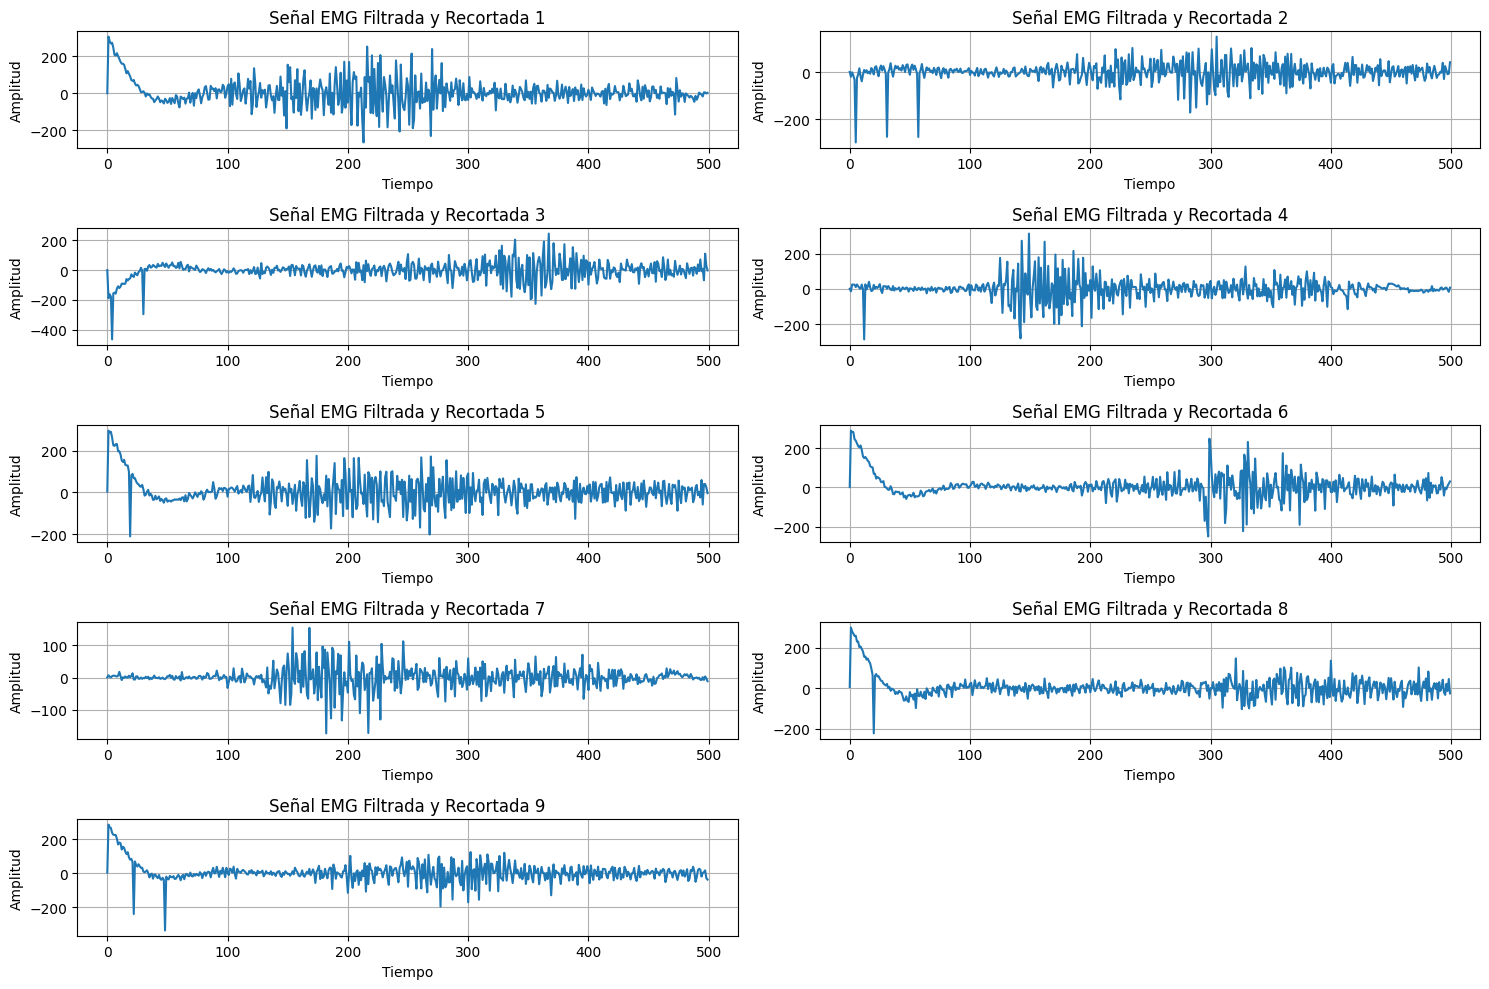

In [ ]:
# Definir el intervalo de tiempo de interés
start_time = 0
end_time = 500

# Recortar las señales EMG filtradas
contraccion = []
for filtered_signal_emg in filtered_signals_emg:
    contraccion.append(filtered_signal_emg[start_time:end_time])

# Tramar las señales EMG recortadas
plt.figure(figsize=(15, 10))
for i, contraccion_signal in enumerate(contraccion, start=1):
    plt.subplot(5, 2, i)
    plt.plot(range(start_time, end_time), contraccion_signal)
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EMG Filtrada y Recortada {i}')
    plt.grid(True)

plt.tight_layout()
plt.show()


# **Cálculo de parámetros a las 9 señales EMG filtradas y recortadas**

In [ ]:
import numpy as np

# Función para calcular Root Mean Square (RMS)
def calcular_rms(signal):
    return np.sqrt(np.mean(signal**2))

# Función para calcular Varianza
def calcular_varianza(signal):
    return np.var(signal)

# Función para calcular Mean Absolute Value (MAV)
def calcular_mav(signal):
    return np.mean(np.abs(signal))

# Función para calcular la pendiente del valor absoluto medio (MAV Slope)
def calcular_mav_slope(signal):
    mav = calcular_mav(signal)
    return np.mean(np.abs(np.diff(signal))) / len(signal)

# Función para contar los cambios de signo en la pendiente
def contar_cambios_signo_slope(signal):
    slope = np.diff(signal)
    return np.sum(slope[:-1] * slope[1:] < 0)

# Función para calcular Waveform Length
def calcular_waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

# Función para contar el número de cruces por cero
def contar_zero_crossing(signal):
    return np.sum(np.diff(np.sign(signal)) != 0)

# Calcular características para cada señal en contraccion
rms_list = [calcular_rms(signal) for signal in contraccion]
varianza_list = [calcular_varianza(signal) for signal in contraccion]
mav_list = [calcular_mav(signal) for signal in contraccion]
mav_slope_list = [calcular_mav_slope(signal) for signal in contraccion]
cambios_signo_slope_list = [contar_cambios_signo_slope(signal) for signal in contraccion]
waveform_length_list = [calcular_waveform_length(signal) for signal in contraccion]
zero_crossing_list = [contar_zero_crossing(signal) for signal in contraccion]

# Imprimir los resultados
for i in range(len(contraccion)):
    print(f"Señal {i+1}:")
    print(f"RMS: {rms_list[i]}")
    print(f"Varianza: {varianza_list[i]}")
    print(f"Mean Absolute Value (MAV): {mav_list[i]}")
    print(f"Mean Absolute Value Slope (MAV Slope): {mav_slope_list[i]}")
    print(f"Slope Sign Changes: {cambios_signo_slope_list[i]}")
    print(f"Waveform Length: {waveform_length_list[i]}")
    print(f"Zero Crossing: {zero_crossing_list[i]}")
    print()


Señal 1:
RMS: 73.37461035136864
Varianza: 5352.900130967608
Mean Absolute Value (MAV): 49.89991911613129
Mean Absolute Value Slope (MAV Slope): 0.13285274972445021
Slope Sign Changes: 330
Waveform Length: 33146.761056250325
Zero Crossing: 244

Señal 2:
RMS: 43.33780765817235
Varianza: 1877.744663037852
Mean Absolute Value (MAV): 27.710894595374892
Mean Absolute Value Slope (MAV Slope): 0.08915267597758776
Slope Sign Changes: 327
Waveform Length: 22243.592656408146
Zero Crossing: 262

Señal 3:
RMS: 62.53119168505925
Varianza: 3892.1790958280008
Mean Absolute Value (MAV): 41.29148575320269
Mean Absolute Value Slope (MAV Slope): 0.11056522417169537
Slope Sign Changes: 320
Waveform Length: 27586.023430837995
Zero Crossing: 235

Señal 4:
RMS: 61.44673608318699
Varianza: 3775.6824622678173
Mean Absolute Value (MAV): 37.84210739920053
Mean Absolute Value Slope (MAV Slope): 0.12031630476166505
Slope Sign Changes: 341
Waveform Length: 30018.91803803543
Zero Crossing: 258

Señal 5:
RMS: 67.91539

In [ ]:
# Calcular promedio de cada característica
promedio_rms = np.mean(rms_list)
promedio_varianza = np.mean(varianza_list)
promedio_mav = np.mean(mav_list)
promedio_mav_slope = np.mean(mav_slope_list)
promedio_cambios_signo_slope = np.mean(cambios_signo_slope_list)
promedio_waveform_length = np.mean(waveform_length_list)
promedio_zero_crossing = np.mean(zero_crossing_list)

# Imprimir los promedios
print("Promedio de todas las características:")
print(f"Promedio RMS: {promedio_rms}")
print(f"Promedio Varianza: {promedio_varianza}")
print(f"Promedio Mean Absolute Value (MAV): {promedio_mav}")
print(f"Promedio Mean Absolute Value Slope (MAV Slope): {promedio_mav_slope}")
print(f"Promedio Slope Sign Changes: {promedio_cambios_signo_slope}")
print(f"Promedio Waveform Length: {promedio_waveform_length}")
print(f"Promedio Zero Crossing: {promedio_zero_crossing}")


Promedio de todas las características:
Promedio RMS: 57.38417767176174
Promedio Varianza: 3402.1243138169702
Promedio Mean Absolute Value (MAV): 37.18241847078402
Promedio Mean Absolute Value Slope (MAV Slope): 0.10000007652421408
Promedio Slope Sign Changes: 330.6666666666667
Promedio Waveform Length: 24950.01909279141
Promedio Zero Crossing: 247.44444444444446


Se utilizará el parámetro de la varianza para establecer el umbral adecuado para la caracterización de los gestos de flexión y extensión.